In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

RiverSense


In [2]:
import geemap as emap
import ee
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# ee.Authenticate()

Enter verification code: 4/3AHp5uHml91sqRO6fa-hWofYsr9Yq28pHVsdnYv5YgZ7w9JkCgYefUA

Successfully saved authorization token.


In [5]:
ee.Initialize()

In [6]:
(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage) = ([16], 
                                                                                [30], 
                                                                                'LANDSAT/LC08/C01/T1_TOA', 
                                                                                '2013-05-01', '2020-05-01', 
                                                                                5)

In [7]:
coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
        .filter(ee.Filter.inList('WRS_PATH', path_list))\
        .filter(ee.Filter.inList('WRS_ROW', row_list))\
        .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))
image_ids = list(map(lambda x: x['id'], coll.getInfo()['features']))

images = list(map(lambda x: ee.Image(x), image_ids))

# Getting Interesting Slice
Even though the scale in image from thumb url is different, the relative position of the objects in the scene will be same. $\therefore$ get the position of the bounding rectangle w.r.t the fixed point. 

I have the following algorithm in mind:

- (Do the pruning of features using Eigen Decomposition (or any PCA)).
- Get the scenes with the least cloud cover $\rightarrow$ Scenes.
- Project it to the pixel space.
- Get the Bounding rectangle in relative coordinates:
- For Image in Scenes:
    - Project the bounding rectangle in the lat/lon.
    - Get the training Data Samples. (Can I use same trained model to segment all the Image ?)
    - Get the region of interest.
    - Split the image in K clusters.
    - Get Average NDWI for each cluster, $kNdwi \leftarrow \{ Ndwi_i\}_{i = 0}^{k}$
    - $WaterCluster := argmax_{i}(kNDWI)$
    - Vectorize WaterCluster to compute the $Area_{Image}$ by PixelCount.
    - $AreaHistory \leftarrow Area_{Image}$
- Return AreaHistory

## Points to Ponder:
- How to measure accuracy of classification w/o external involvement?
- 

In [16]:
Map = emap.Map()

Img = images[0].select(['B7'])
Region         = Img.geometry().bounds().getInfo()
Region

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[-78.45070344271478, 42.112163622924264],
   [-75.58511912465933, 42.112163622924264],
   [-75.58511912465933, 44.24236846087388],
   [-78.45070344271478, 44.24236846087388],
   [-78.45070344271478, 42.112163622924264]]]}

In [14]:
Map.addLayer((Img), {'min': 0, 'max': 0.05, 'opacity':0.95}, 'Base')

Map.setCenter(lon=(RoiBound[0] + RoiBound[2])/2, 
              lat=(RoiBound[1] + RoiBound[3])/2, 
              zoom=9)
Map

Map(center=[42.77726604189907, -77.31791128368705], controls=(WidgetControl(options=['position'], widget=HBox(…

In [16]:
!git log

commit 2f9e011a6d7e0ac21d5df913be7cf54cc02e0cad
Author: PrabhakarMNaik <pmn2119@columbia.edu>
Date:   Thu Aug 20 10:00:55 2020 -0400

    string

commit ff2d50444c003d51b223f0698606d5bed92b494b
Author: PrabhakarMNaik <pmn2119@columbia.edu>
Date:   Thu Aug 20 09:50:56 2020 -0400

    Second Commit, adding TutGeeRs

commit 30e52ba17631e7e133f272fa7d912c35dae921c5
Author: PrabhakarMNaik <pmn2119@columbia.edu>
Date:   Thu Aug 20 09:35:02 2020 -0400

    First Commit, adding TutGeeRs


Appended
Appended
Appended
Appended
Appended
Appended
Appended
Appended
Appended
Appended


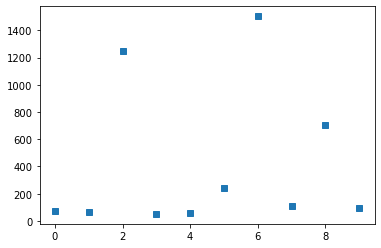

In [16]:
Map = emap.Map()
LakeArea = []
WaterImages = []
count = 0
for image in images:
    count +=1
    Img = image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'B10', 'B11', 'BQA'])

#     Map            = emap.Map()
    Region         = Img.geometry().bounds().getInfo()

    Offset         = [-1, -0.40, 1.45, 1.15]
    Bound          = [Region['coordinates'][0][0][0],
                      Region['coordinates'][0][0][1], 
                      Region['coordinates'][0][2][0],
                      Region['coordinates'][0][2][1]]
    RoiBound       = [Bound[i] - Offset[i] for i in range(4)]
    Roi            = ee.Geometry.Rectangle(RoiBound)
    TrainingRegion = ee.Geometry.Rectangle(Bound)
#     Map.addLayer(Roi, {'color': 'yellow'}, 'Roi')
#     Map.addLayer(TrainingRegion, {'color': '000000'}, 'Training')
#     Map.addLayer(Img, {'min': 0, 'max': 1, 'opacity':0.95}, 'Base')

# Map

    Training       = Img.sample(region = TrainingRegion,
                            scale = 30.0, 
                            numPixels = 750)

    NumCluster     = 3
    Clusterer      = ee.Clusterer.wekaKMeans(NumCluster).train(Training)
    #     Img            = Img.clip(Roi)
    Clusters       = Img.cluster(Clusterer).clip(Roi)

    water          = Clusters.select("cluster").eq(2).selfMask()
    WaterImages.append(water)

    Map.addLayer(water,
                 {'min': 0, 
                  'max': NumCluster, 
                  'palette': ['red'], 
                  'opacity':0.95},
                 str(count))

    #     Map.add_ee_layer(Clusters, 
    #                      {'min': 0, 
    #                       'max': NumCluster, 
    #                       'palette': ['white', 'green', 'blue'], 
    #                       'opacity':0.95}, 
    #                      'clustering')

    area_water = water.multiply(ee.Image.pixelArea()).divide(1000*1000)

    areas = area_water.reduceRegion(reducer  =ee.Reducer.sum(),
                                    geometry = Roi,
                                    scale    = 30, 
                                    maxPixels= 1e13)
    LakeArea.append(areas.getInfo()['cluster'])
    print('Appended')

plt.plot(LakeArea, 's')

In [19]:
!git add TutGeeRs01.ipynb
!git commit -m "Algorithm Added"
!git status

The file will have its original line endings in your working directory


[master 7f814b5] Algorithm Added
 1 file changed, 66 insertions(+), 35 deletions(-)
On branch master
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	LANDSAT_8_C1_432396.txt
	ScratchPad.ipynb
	Untitled1.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [25]:
# !git remote add origin https://github.com/PrabhakarMNaik/WaterSense.git
!git pull 

From https://github.com/PrabhakarMNaik/RiverSense
 * [new branch]      master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master



In [26]:
!git push origin master

To https://github.com/PrabhakarMNaik/RiverSense.git
 ! [rejected]        master -> master (non-fast-forward)
error: failed to push some refs to 'https://github.com/PrabhakarMNaik/RiverSense.git'
hint: Updates were rejected because the tip of your current branch is behind
hint: its remote counterpart. Integrate the remote changes (e.g.
hint: 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.
